In [1]:
import os
os.chdir("..")


In [2]:
%load_ext autoreload 

In [3]:
%autoreload 2
from src.transforms.motion_transform import MotionTsfd
from src.transforms.base_transform import Preprocess,Augment
from src.dataset.hcp_dataset import HCP
import matplotlib.pyplot as plt
import torchio as tio

/opt/anaconda/envs/bowl/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
ds = HCP.lab(Preprocess())

Loading dataset: 100%|██████████| 1113/1113 [20:07<00:00,  1.08s/it]


(metatensor(0.9776), metatensor(0.))

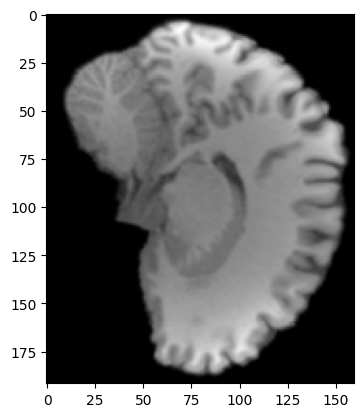

In [6]:
vol = ds[0]["data"]
plt.imshow(vol[0,60,:,:], cmap="gray")
vol.max(), vol.min()

In [7]:
motion =MotionTsfd()

Loading dataset: 100%|██████████| 100/100 [00:38<00:00,  2.63it/s]


torch.Size([1, 160, 192, 160])

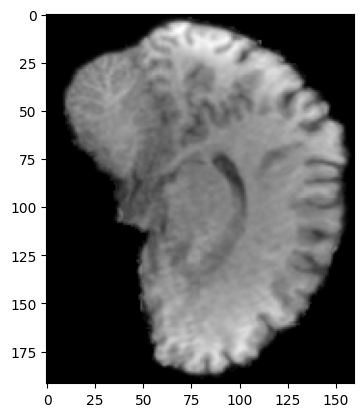

In [12]:
vol = motion(ds[0])["data"]
plt.imshow(vol[0,60,:,:], cmap="gray")
vol.shape

(tensor(1.0120), tensor(-0.2100))

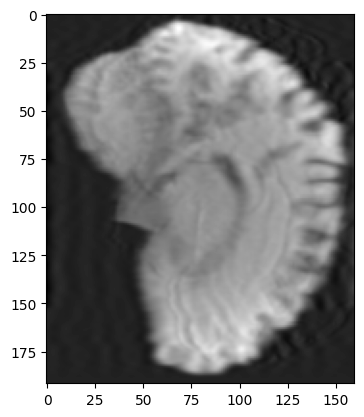

In [25]:
aug=tio.transforms.RandomMotion()
vol = aug(ds[0]["data"])
plt.imshow(vol[0,60,:,:], cmap="gray")
vol.max(), vol.min()

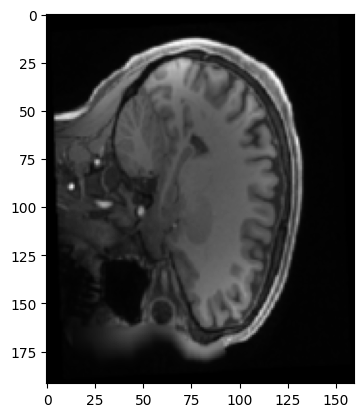

In [29]:
unp = Preprocess()({"data":"/home/at70870/narval/scratch/MRIQC/sub-HCP-YA-1200-110613/110613_3T_T1w_MPR1/mri/orig_nu.nii.gz"})
plt.imshow(unp['data'][0,60,:,:], cmap="gray")


(tensor(1.0253), tensor(-0.1008))

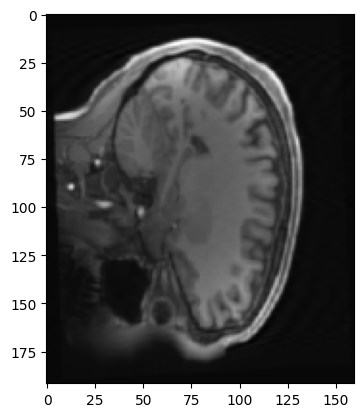

In [120]:
aug=tio.transforms.RandomMotion(degrees=2, translation=2,num_transforms=1)
vol = aug(unp["data"])
plt.imshow(vol[0,60,:,:], cmap="gray")
vol.max(), vol.min()

(metatensor(0.3575), metatensor(-0.3037))

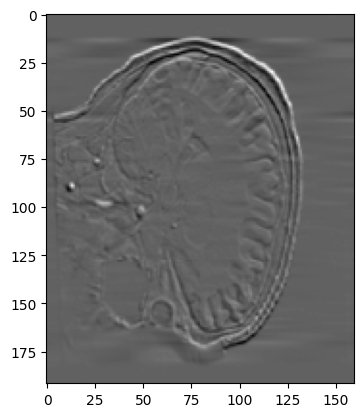

In [131]:
aug=tio.transforms.RandomMotion(degrees=2, translation=2,num_transforms=1)
vol = unp["data"] - aug(unp["data"])
plt.imshow(vol[0,60,:,:], cmap="gray")
vol.max(), vol.min()